# Fraud Prevention analysis
This data came from some company that deals with fraudelent transactions. The exercise is about manipulate the corresponding that contains information about the transaction and wheather or not the transaction is fraudelent.
Besides some dictionaries are added in order to join this information in the main database.

In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [195]:
#library options 
# pandas options for data manipulation
pd.options.display.float_format = '{:,}'.format
pd.options.display.precision = 1
# seaborn options for data visualization
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.3) 
palette = sns.color_palette("mako_r", 2)                                          

In [3]:
#importing files
base = pd.read_table('base.txt', sep='|')
estado = pd.read_excel('Prueba_diccionario.xlsx', sheet_name='estado', engine='openpyxl')
accion = pd.read_excel('Prueba_diccionario.xlsx', sheet_name='acción', engine='openpyxl')
franquicia = pd.read_excel('Prueba_diccionario.xlsx', sheet_name='franquicia', engine='openpyxl')

# 1. Variable Generation

In [4]:
# 'fecha' 
base['fecha_trx'] = pd.to_datetime(base.fecha_trx, format='%Y-%m-%d %H:%M:%S')
base['fecha'] = base['fecha_trx'].dt.strftime('%d/%m/%Y')

In [5]:
# 'estado_descripcion'
base = base.join(estado.set_index('Estado'), on='estado')
base.rename(columns={'Descripción':'estado_descripcion'}, inplace=True)

In [6]:
# 'accion_descripcion'
base = base.join(accion.set_index('accion_id'), on='accion', rsuffix='_z')
base.rename(columns={'accion_z':'accion_descripcion'}, inplace=True)

In [7]:
# 'franquicia_descripcion'
base = base.join(franquicia.set_index('medio_pago_id'), on='franquicia')
base.rename(columns={'medio_pago':'franquicia_descripcion'}, inplace=True)

In [8]:
# 'transaccion_fraude'
base['transaccion_fraude'] = base['fraude'].replace([0,1],['No Fraude', 'Fraude'])

In [63]:
# data segmentation in both cases: fraud and no_fraud, for analysis purposes
fraud = base[base['transaccion_fraude'] == 'Fraude']
no_fraud = base[base['transaccion_fraude'] != 'Fraude']

In [64]:
# dataframe generation grouping by franquicia_descripcion' and month for no_fraud. Sum and mean of values
sum_n = no_fraud.groupby(['franquicia_descripcion', no_fraud['fecha_trx'].dt.month])['valor_trx'].sum().round()
sum_n.loc['Total general'] = sum_n.sum(axis=0).round()
mean_n = no_fraud.groupby(['franquicia_descripcion', no_fraud['fecha_trx'].dt.month])['valor_trx'].mean().round()
mean_n.loc['Total general'] = mean_n.mean(axis=0).round()

In [65]:
# concatenintg both df to create the final df
df = pd.concat([sum_n, mean_n], axis=1)
df.columns = ['Monto Total', 'Monto Promedio']
df.index.rename(['Franquicia', 'Mes'], inplace=True)

In [66]:
df

Monto Total  Monto Promedio
Franquicia    Mes                                  
AMEX          6     1,788,092,162.0       883,881.0
              7     2,667,799,705.0       674,880.0
DINERS        6       456,858,009.0       767,829.0
              7       706,671,537.0       651,310.0
MASTERCARD    6    21,218,699,966.0       803,130.0
              7    35,396,522,721.0       677,549.0
PSE           6    24,463,568,167.0       474,330.0
              7       198,649,730.0       357,284.0
VISA          6    26,480,944,650.0       819,311.0
              7    43,130,128,309.0       724,304.0
Total general     156,507,934,956.0       683,381.0

In [76]:
df.to_csv('no_fraude_fm.csv')

In [73]:
sum_f = fraud.groupby(['franquicia_descripcion', fraud['fecha_trx'].dt.month])['valor_trx'].sum().round()
sum_f.loc['Total general'] = sum_f.sum(axis=0).round()
mean_f   = fraud.groupby(['franquicia_descripcion', fraud['fecha_trx'].dt.month])['valor_trx'].mean().round()
mean_f.loc['Total general'] = mean_f.mean(axis=0).round()

In [74]:
df1 = pd.concat([sum_f, mean_f], axis=1)
df1.columns = ['Monto Total', 'Monto Promedio']
df1.index.rename(['Franquicia', 'Mes'], inplace=True)

In [75]:
df1

Monto Total  Monto Promedio
Franquicia    Mes                                
AMEX          6      21,097,945.0     1,406,530.0
              7      16,789,951.0     1,199,282.0
DINERS        6          56,932.0        56,932.0
              7         275,000.0       275,000.0
MASTERCARD    6     296,821,694.0       963,707.0
              7     505,338,428.0       973,677.0
VISA          6   1,008,496,272.0       960,473.0
              7   1,140,880,682.0       855,233.0
Total general     2,989,756,904.0       836,354.0

In [77]:
df1.to_csv('fraude_fm.csv')

# Exploratory Data Analysis (EDA)
### Variable distribution for 'valor_trx' in fraud cases

<AxesSubplot:xlabel='valor_trx'>

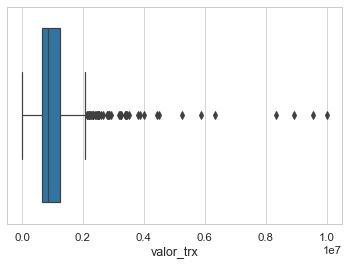

In [79]:
sns.boxplot(x='valor_trx', data=fraud)

(0.0, 3000000.0)

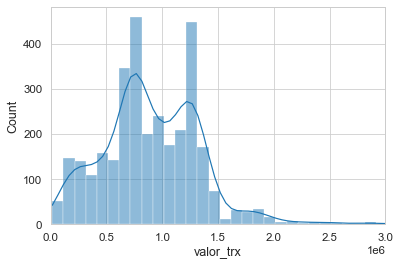

In [80]:
sns.histplot(x='valor_trx', data=fraud, binwidth=100000, kde=True)
plt.xlim(0,0.3e7)

(0.0, 2000000.0)

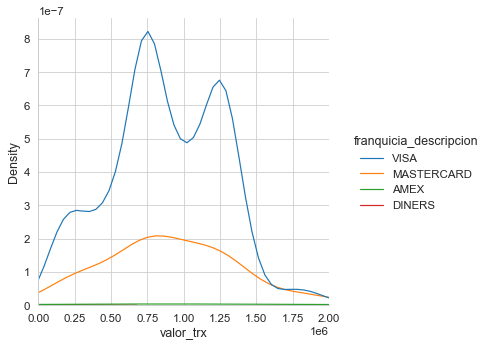

In [81]:
sns.displot(x='valor_trx', data=fraud, hue='franquicia_descripcion', kind='kde')
plt.xlim(0,0.2e7)

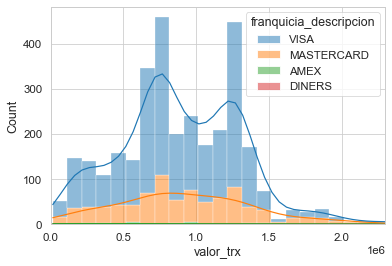

In [141]:
sns.histplot(x='valor_trx', data=fraud, hue='franquicia_descripcion', alpha=0.5, stat='count', kde=True, binwidth=100000, multiple='stack', legend=True)
plt.xlim(0,0.23e7)
plt.savefig('f_hist.pdf')

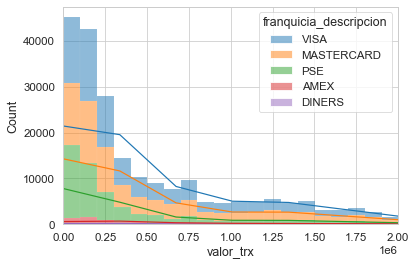

In [143]:
sns.histplot(x='valor_trx', data=no_fraud, hue='franquicia_descripcion', stat='count', kde=True, binwidth=100000, multiple='stack')
plt.xlim(0,0.2e7)
plt.savefig('nf_hist.pdf')

In [84]:
no_fraud['valor_trx'].median()

298137.0

In [85]:
fraud['valor_trx'].mean()

922195.2202344232

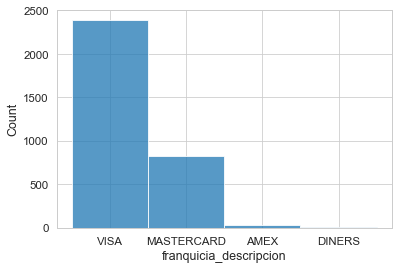

In [146]:
sns.histplot(x='franquicia_descripcion', data=fraud, stat='count')
plt.savefig('f_fran_c.pdf')

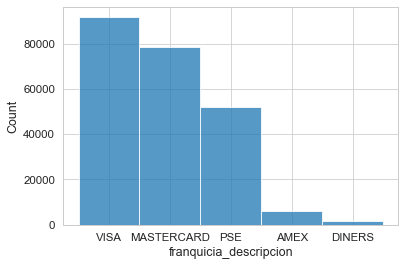

In [147]:
sns.histplot(x='franquicia_descripcion', data=no_fraud, stat='count')
plt.savefig('nf_fran_c.pdf')

In [88]:
fraud.emisor.value_counts().head(10)

BANCOLOMBIA                 538
BANCO DE BOGOTA             481
BANCO DAVIVIENDA            451
BANCO BILBAO VIZCAY         332
COLPATRIA RED MULTIBANCA    305
CITIBANK                    304
SCOTIABANK                  189
TUYA                        104
BBVA COLOMBIA                78
HELM BANK                    67
Name: emisor, dtype: int64

In [89]:
fraud.ser_telefonia.value_counts().head(10)

Claro Colombia                                  1041
TIGO COLOMBIA                                    787
Movistar Colombia                                582
Telmex Colombia S.A.                             230
ETB                                              115
UNE                                              103
Avantel SAS                                      100
Comcel S.A.                                       82
DIRECTV Colombia                                  19
Empresas Municipales De Cali E.i.c.e. E.s.p.      12
Name: ser_telefonia, dtype: int64

In [90]:
fraud.ser_telefonia.unique()

array(['Shaw Communications', 'Telmex Colombia S.A.', 'Movistar Colombia',
       'Claro Colombia', 'TIGO COLOMBIA', 'UNE', 'ETB', 'Avantel SAS',
       'Hetzner Online GmbH', 'TV AZTECA SUCURSAL COLOMBIA',
       'DIRECTV Colombia', 'Pacifico Cable', 'Comcel S.A.',
       'Columbus Networks USA', 'Telefonica de Espana', 'Cablecolor S.A.',
       'Falco Networks', 'Empresas Municipales De Cali E.i.c.e. E.s.p.',
       'Empresa de Recursos Tecnologicos S.A E.S.P',
       'Internexa S.A. E.s.p', 'OVH Hosting', 'Microsoft Corporation',
       'Level 3 Communications', 'Bulsatcom EAD', 'Artmotion Sh.p.k.',
       'DataCamp s.r.o.', 'QuadraNet', 'Media Commerce Partners S.A',
       'Digital Ocean', 'ALBtelecom', 'Net3', 'A1 Bulgaria', 'Transbeam',
       'Telefonica de Espana Static IP', 'AT T U-verse', 'TelKos L.L.C',
       'Ufinet Panama S.A.', 'Corporacion Digitel C.A.', nan, 'izzi',
       'Vivacom', 'Unus', 'Comcast Cable', 'Virgin Media',
       '1 1 Internet AG', 'Telekom Srbija', 

In [91]:
fraud['ser_telefonia']=fraud['ser_telefonia'].replace('Telmex Colombia S.A.', 'Claro Colombia')
fraud['ser_telefonia']=fraud['ser_telefonia'].replace('Comcel S.A.', 'Claro Colombia')

In [92]:
tel = fraud['ser_telefonia'].value_counts().head(8)

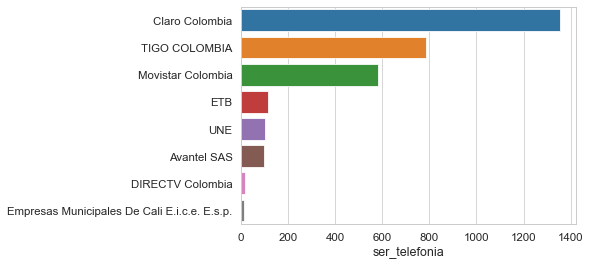

In [148]:
sns.barplot(y=tel.index, x=tel)
plt.savefig('f_tel_c.pdf')

In [94]:
no_fraud['ser_telefonia']=no_fraud['ser_telefonia'].replace('Telmex Colombia S.A.', 'Claro Colombia')
no_fraud['ser_telefonia']=no_fraud['ser_telefonia'].replace('Comcel S.A.', 'Claro Colombia')
tel_no = no_fraud['ser_telefonia'].value_counts().head(8)

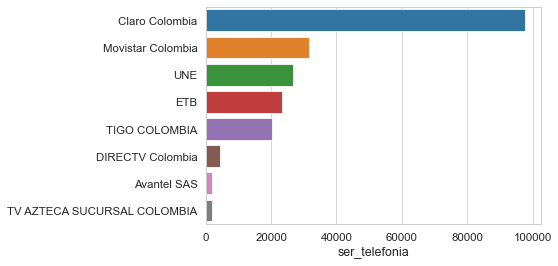

In [149]:
sns.barplot(y=tel_no.index, x=tel_no)
plt.savefig('nf_tel_c.pdf')

# Numero de casos medios de fraude por hora y por dia en el periodo Considerado

In [161]:
hora = fraud.resample('H', on='fecha_trx').count()

In [162]:
hora = hora.groupby([hora.index.month, hora.index.hour]).mean()

In [204]:
hora.index.rename(['Month', 'Hour'], inplace=True)

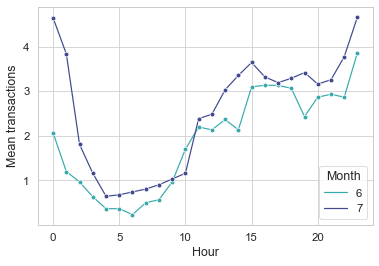

In [205]:
sns.lineplot(x=hora.index.get_level_values(1), y=hora.cod_trx, hue=hora.index.get_level_values(0), marker='o', palette=palette)
plt.ylabel('Mean transactions')
plt.savefig('f_hour_t.pdf')

In [206]:
dia = fraud.resample('D', on='fecha_trx').count()

In [207]:
dia = dia.groupby([dia.index.month, dia.index.dayofweek]).mean()

In [208]:
dia.index.rename(['Month', 'Day'], inplace=True)

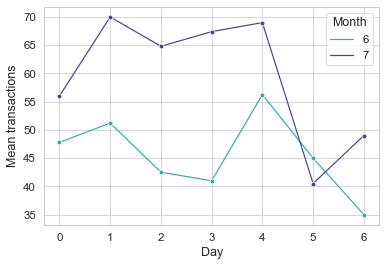

In [209]:
sns.lineplot(x=dia.index.get_level_values(1), y=dia.cod_trx, hue=dia.index.get_level_values(0), marker='o', palette=palette)
plt.ylabel('Mean transactions')
plt.savefig('f_day_t.pdf')